### Connect to Drive

### Import libraries

In [38]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42
sequence_length = 10
sequence_stride = 1
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Load and clean the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Air hockey challenge/Dataset

/content/drive/MyDrive/Air hockey challenge/Dataset


In [5]:
x = pd.read_excel('x/1.xlsx', sheet_name=None)
y = pd.read_excel('y/1.xlsx', sheet_name=None)

In [6]:
x["df1"].head

<bound method NDFrame.head of      puck current pos X  puck current pos Y  puck current pos Yaw  \
0              2.022091            0.236163              0.014524   
1              1.972279            0.196777             -0.169230   
2              1.911964            0.232883             -0.244498   
3              1.851170            0.144931             -0.361126   
4              1.775325            0.173001             -0.555899   
..                  ...                 ...                   ...   
200            2.185495            0.225285              2.384570   
201            2.178764            0.218067              2.284151   
202            2.180324            0.206415              2.234958   
203            2.216046            0.252831              2.172705   
204            2.219644            0.248232              2.028810   

     puck current vel X  puck current vel Y  puck current vel Yaw  
0             -2.460408           -1.074499             -6.945896  
1    

**sequencing the data, then train and test splitting**

In [7]:
def cutting_into_sequence(sequence_length, sequence_stride, data):
    sequences_data = []
    
    num_rows = len(data)

    for i in range(0, num_rows - sequence_length + 1, sequence_stride):
        sequence_data = data.iloc[i:i+sequence_length]
        sequences_data.append(sequence_data)

    return sequences_data

In [8]:
# cut the data into sequences
x_total_list = []
y_total_list = []
for sheet_name, df in x.items():
    x_total_list += cutting_into_sequence(sequence_length, sequence_stride, df)

for sheet_name, df in y.items():
    y_total_list += cutting_into_sequence(sequence_length, sequence_stride, df)


In [9]:
x_total = np.array(x_total_list)
y_total = np.array(y_total_list)[:,-1,:2]

In [10]:
y_total.shape

(15466, 2)

In [11]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=0.2)


**Here I calculated the mean and the variance of each feature that I have, I normalize the position of the puck to zero mean and veriance one**

In [12]:
mean_of_data = np.mean(np.mean(x_train, axis=1), axis=0)

In [13]:
var_of_data = np.var(np.var(x_train, axis=1), axis=0)

In [14]:
# x_train[:,:,0] = (x_train[:,:,0] - mean_of_data[0]) / var_of_data[0]
# x_train[:,:,1] = (x_train[:,:,1] - mean_of_data[1]) / var_of_data[1]

In [15]:
np.mean(np.mean(x_train, axis=1), axis=0)

array([ 1.40511573,  0.04113749, -0.05592986, -0.08408599, -0.00531452,
        0.53935448])

In [16]:
np.var(np.var(x_train, axis=1), axis=0)

array([1.74727991e-04, 5.10438952e-06, 4.48675186e+00, 4.38504368e+00,
       2.20592180e-01, 1.38770767e+03])

### Build and train models

In [17]:
x_train.shape[1:]

(10, 6)

In [18]:
input_shape = x_train.shape[1:]
output_shape = 2
batch_size = 128
epochs = 400

In [19]:
input_shape

(10, 6)

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

In [26]:
def build_LSTM_classifier(input_shape, output_dim):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(32)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    reg = tfkl.Dense(16, activation='relu')(dropout)
    output_layer = tfkl.Dense(output_dim)(lstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model

In [27]:
model = build_LSTM_classifier(input_shape, output_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            4992      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 13,378
Trainable params: 13,378
Non-trainable params: 0
_________________________________________________________________


In [28]:
x_train.shape

(12372, 10, 6)

In [29]:
y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [30]:
type(x_train[0][0][0])

numpy.float32

In [31]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        # tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/400
87/87 [==============================] - 5s 17ms/step - loss: 0.2018 - val_loss: 0.0514 - lr: 0.0010
Epoch 2/400
87/87 [==============================] - 1s 10ms/step - loss: 0.0195 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/400
87/87 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0032 - lr: 0.0010
Epoch 4/400
87/87 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0020 - lr: 0.0010
Epoch 5/400
87/87 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0010
Epoch 6/400
87/87 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0010 - lr: 0.0010
Epoch 7/400
87/87 [==============================] - 1s 10ms/step - loss: 9.4993e-04 - val_loss: 8.7678e-04 - lr: 0.0010
Epoch 8/400
87/87 [==============================] - 1s 10ms/step - loss: 7.6822e-04 - val_loss: 7.9053e-04 - lr: 0.0010
Epoch 9/400
87/87 [==============================] - 1s 10ms/step - loss: 6.5168

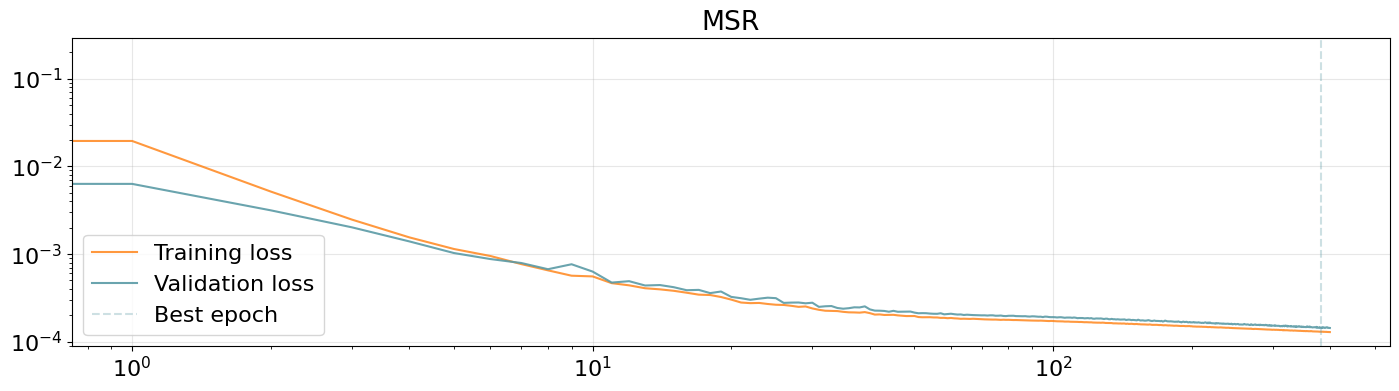

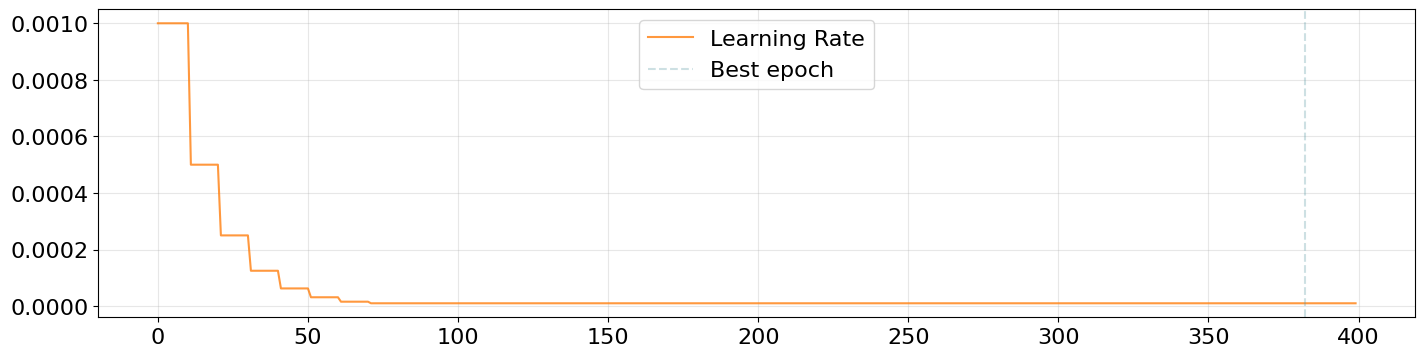

In [32]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.loglog(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.loglog(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('MSR')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [33]:
model.save('LSTM')
# model = tfk.models.load_model('LSTM')

In [34]:
# Predict the test set with the LSTM
predictions = model.predict(x_test)


97/97 [==============================] - 1s 2ms/step


In [43]:
# Compute the test error

errors = mean_squared_error(y_test, predictions)

errora = mean_absolute_error(y_test, predictions)


In [44]:
print(f'mean S error : {errors}')
print(f'mean A error : {errora}')

mean S error : 0.00013216991267801938
mean A error : 0.00887922817434527


In [45]:

errors = mean_squared_error(y_train, x_train[:,-1,:2])

errora = mean_absolute_error(y_train, x_train[:,-1,:2])


In [46]:
print(f'mean S error : {errors}')
print(f'mean A error : {errora}')

mean S error : 0.0010001531336456537
mean A error : 0.025240734219551086


#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1CN-jJqzb5AurhnMMiuvdVCaPGy2KReLc
)

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('BiLSTM')
# model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

In [67]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model

In [68]:
output_shape

2

In [69]:
model = build_1DCNN_classifier(input_shape, output_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10, 6)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 10, 128)           2432      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 128)            49280     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 128)               0     

In [70]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        # tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
87/87 [==============================] - 2s 14ms/step - loss: 0.2800 - val_loss: 0.2724 - lr: 0.0010
Epoch 2/200
87/87 [==============================] - 1s 13ms/step - loss: 0.2635 - val_loss: 0.2720 - lr: 0.0010
Epoch 3/200
87/87 [==============================] - 1s 13ms/step - loss: 0.2628 - val_loss: 0.2714 - lr: 0.0010
Epoch 4/200
87/87 [==============================] - 1s 10ms/step - loss: 0.2607 - val_loss: 0.2671 - lr: 0.0010
Epoch 5/200
87/87 [==============================] - 1s 9ms/step - loss: 0.2576 - val_loss: 0.2629 - lr: 0.0010
Epoch 6/200
87/87 [==============================] - 1s 9ms/step - loss: 0.2540 - val_loss: 0.2619 - lr: 0.0010
Epoch 7/200
87/87 [==============================] - 1s 9ms/step - loss: 0.2533 - val_loss: 0.2617 - lr: 5.0000e-04
Epoch 8/200
87/87 [==============================] - 1s 8ms/step - loss: 0.2529 - val_loss: 0.2615 - lr: 5.0000e-04
Epoch 9/200
87/87 [==============================] - 1s 9ms/step - loss: 0.2526 - val_loss: 

KeyboardInterrupt: ignored

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1DCNN')
# model = tfk.models.load_model('1DCNN')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Damn, once again no free lunch